# Introduction

Short notebook to get an overview of model performance across architectures and dimensionality.

Here we share some code to train a model from scratch and our procedure for evaluating and selecting models to study.

For each architecture (RNN, GRU, LSTM, NM-RNN) and dimensionality (1 or 2 hidden units) we fit a model to predict a subject's (WS16) choices during a 2-armed bandit task (75% reward probability at 'good poke' and 25% reward probability at the other poke). Note that in this data there are forced choice trials, but the loss associated with these predictions are excluded (since forced choices are random and cannot be predicted well).

All trials for a subject are split into train (80%), validation (10%), an evaluation (10%), seeded deterministically across models and repeated for 10 different seeds. 

Training is done with an early stop on validation prediction errors within each model type but across hyperparameters (varying sparsity). 

Then across models we compare performance on evaluation prediction errors. 

We then select the median performing model on the evaluation performance, so as not to overfit the transfer learning variability across splits.

We further study how these models predict the behaviour in the `mechanisms` notebook!

In [1]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git
from pathlib import Path
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


fatal: destination path 'NM_TinyRNN' already exists and is not an empty directory.


In [1]:
# local setup 

#may need to change directory to import the below
CODE_DIR = Path(r'C:\Users\owner\Research\NM_TinyRNN') #the directory containing NM_TinyRNN folder

import os
os.chdir(CODE_DIR.parent)

# there's multiple openMP processes on my local, 
# the following is an unsafe, unsupported, undocumented, workaround:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


NameError: name 'Path' is not defined

In [7]:
# general setup:

import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns
from NM_TinyRNN.code.models import parallelised_training as pat
from importlib import reload

CODE_DIR =Path('.') #the directory containing NM_TinyRNN folder

SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = CODE_DIR/'NM_TinyRNN/data/AB_behaviour/WS18'


### Model training

Here we leave a bit of code to show how we train models, first one-by-one and then with a parallelised training approach (on a SLURM managed computing cluster).

In [8]:
# Train some models using the standard code
reload(training)
reload(datasets)
reload(rnns)


SEQUENCE_LENGTH = 150 # sequence length for batched training.

train_seed = 2
#weight_seed = 14

options_dict = {'rnn_type':'monoGRU',
                'input_size':3,
                'hidden_size':2,
                'nonlinearity':'relu',
                'input_encoding':'unipolar',
                'init_decoder':False}

dataset = datasets.AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
model = rnns.TinyRNN(**options_dict)  
min_loss = np.inf
trainer = training.Trainer(SAVE_PATH/'test',
                        batch_size = 8, 
                        max_epochs = 100, 
                        early_stop = 20,
                        train_seed = train_seed,
                        sparsity_lambdas = [1e-5],
                        energy_lambdas = [1e-2],
                        hebbian_lambdas = [None], #interesting idea, doesn't work in practice. We would need to skip the ones with all 0 activity.
                        weight_seeds = [1,2,3,4,5],# [x for x in range(1,21)],
                        learning_rate = 1e-3)

training_losses_df = trainer.fit(model,dataset)

print(f'Best model found with val loss {min_loss}')
# plot losses
fig, ax = plt.subplots(1,4)
ax[0].plot(training_losses_df.val_pred_losses)
ax[1].plot(training_losses_df.train_sparsity)
ax[2].plot(training_losses_df.train_energy)
ax[3].plot(training_losses_df.train_hebbian)
plt.show()  
# also get trials_df
trials_df = trainer.get_model_trial_by_trial_df(model,dataset)
trials_df

Starting training with 1 sparsity values...
Dataset size: 63
Split sizes - Train: 50, Validation: 6, Evaluation: 7

Training with  
 weight seed = 1,
 sparsity lambda = 1e-05, 
 energy lambda = 0.01, 
 hebbian lambda = None


λ=1e-05:   7%|▋         | 7/100 [00:02<00:39,  2.35it/s]


KeyboardInterrupt: 

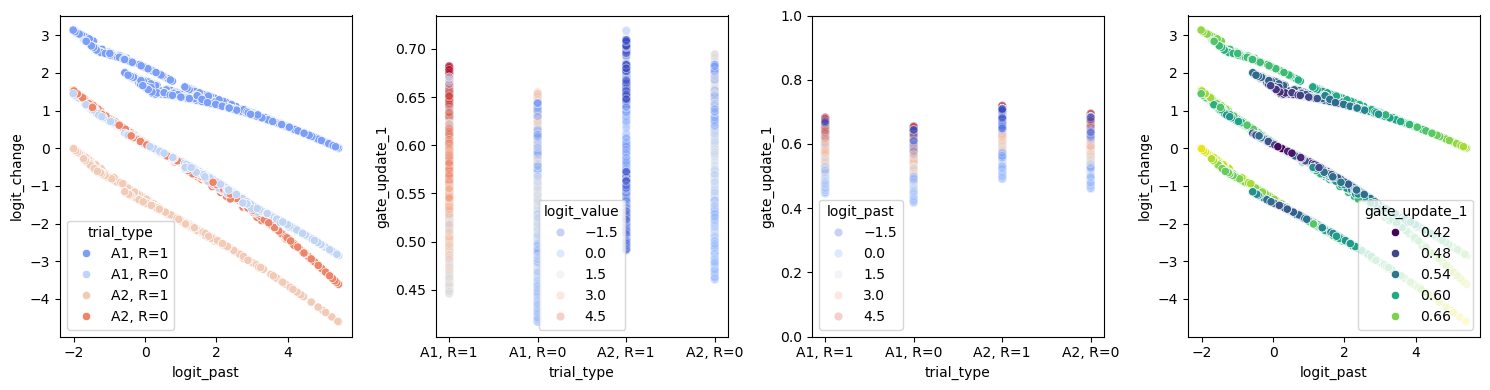

In [4]:
#trials_df = pd.read_csv('/ceph/behrens/wsilver/reversal/code/NM_TinyRNN/data/rnns/run_4_but10epoch/WS18/random_seed_2/monoGRU/energy/weight_seed_14/1_unit_monoGRU_relu_unipolar_trials_data.htsv', sep = '\t')
#trials_df = pd.read_csv('./NM_TinyRNN/data/rnns/run_4/WS18/random_seed_2/monoGRU/energy/weight_seed_17/1_unit_monoGRU_relu_unipolar_trials_data.htsv', sep = '\t')
#trials_df = pd.read_csv('/ceph/behrens/wsilver/reversal/code/NM_TinyRNN/data/rnns/run_4_but10epoch/WS18/random_seed_2/monoGRU/energy/weight_seed_14/1_unit_monoGRU_relu_unipolar_trials_data.htsv', sep='\t')
#trials_df = trainer.get_model_trial_by_trial_df(model,dataset)

fig, ax = plt.subplots(1,4, figsize = (15,4))
sns.scatterplot(trials_df,x='logit_past',y='logit_change', 
                hue = 'trial_type', palette='coolwarm', 
                ax= ax[0])
sns.scatterplot(trials_df, x='trial_type', y='gate_update_1', 
                hue = 'logit_value', palette='coolwarm', 
                ax = ax[1], alpha=0.3)
sns.scatterplot(trials_df, x='trial_type', y='gate_update_1', 
                hue = 'logit_past', palette='coolwarm', 
                ax = ax[2], alpha=0.3)
sns.scatterplot(trials_df, x='logit_past', y='logit_change', 
                hue = 'gate_update_1', palette='viridis', 
                ax = ax[3])
ax[2].set(ylim=(0,1))
fig.tight_layout()

In [22]:

for name, param in model.named_parameters():
    print(name,param)

rnn.W_from_in Parameter containing:
tensor([[ 0.5089,  0.0483, -1.2734, -0.9482,  0.7083,  0.7443],
        [-1.1433,  0.4318,  0.7548, -0.6800, -0.8794,  0.4876]],
       requires_grad=True)
rnn.W_from_h Parameter containing:
tensor([[ 0.4096,  0.4682, -0.0388,  0.9513,  0.5914, -0.4484],
        [-1.3504, -0.1635, -1.9292, -0.3205, -0.2314,  0.3459]],
       requires_grad=True)
rnn.bias Parameter containing:
tensor([-0.0523,  0.3129, -0.5084, -0.1668, -0.0017, -0.2810, -0.0523,  0.3136,
        -0.5093, -0.1665,  0.1517, -0.2290], requires_grad=True)
decoder.weight Parameter containing:
tensor([[ 1.7520, -0.4372],
        [-1.3770,  1.6737]], requires_grad=True)
decoder.bias Parameter containing:
tensor([ 0.0911, -0.1034], requires_grad=True)


[(0.0, 1.0), (0.0, 1.0)]

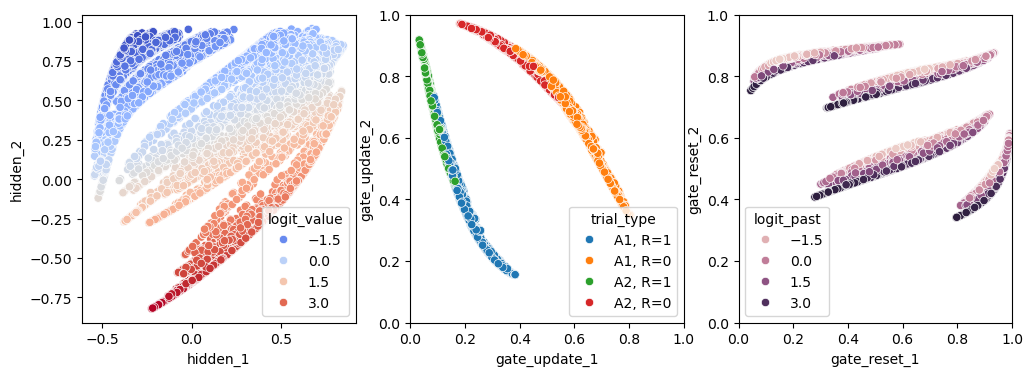

In [58]:
#Gru plots
fig, ax  = plt.subplots(1,3, figsize = (12,4))
sns.scatterplot(trials_df, x='hidden_1', y='hidden_2', 
                hue = 'logit_value', palette='coolwarm', 
                ax = ax[0])
sns.scatterplot(trials_df, x='gate_update_1', y='gate_update_2',
                hue='trial_type',ax = ax[1])
sns.scatterplot(trials_df, x='gate_reset_1', y='gate_reset_2',
                hue = 'logit_past',ax = ax[2])
ax[1].set(xlim=[0,1], ylim=[0,1])
ax[2].set(xlim=[0,1], ylim=[0,1])

In [49]:
for name, param in model.named_parameters():
    print(name, param)

rnn.W_from_in Parameter containing:
tensor([[ 1.2661, -0.6966, -0.7331,  1.6418, -0.2128, -0.3608],
        [-0.9525, -0.4386,  1.7084,  1.5276, -0.3568, -0.2663]],
       requires_grad=True)
rnn.W_from_h Parameter containing:
tensor([[-0.8472,  0.1981, -1.5807,  0.3492,  0.7527, -0.6579],
        [-0.9704, -0.9855,  1.6917,  1.4776,  0.1168,  0.7500]],
       requires_grad=True)
rnn.bias Parameter containing:
tensor([ 0.5017, -0.3257, -0.3141,  0.5724, -0.4183, -0.3234, -0.6424, -0.0806,
        -0.9974,  0.3023,  0.8432,  0.1602], requires_grad=True)
decoder.weight Parameter containing:
tensor([[ 3.2263, -1.7681],
        [-2.6490,  1.8356]], requires_grad=True)
decoder.bias Parameter containing:
tensor([-0.3549,  0.2713], requires_grad=True)


In [29]:
# you can train a bunch of models with pat:

reload(pat)
pat.run_training(overwrite=True) #OBS: this will send jobs ot the cluster !
#info_df = pat.get_DA_info_df()

#info_df.subject_ID.unique()
#pat.train_parallel(DATA_PATH,SAVE_PATH/'test', model_type = 'monoGRU')

Submitting model training for WS20 to HPC
Submitted batch job 1502247
Submitting model training for WS20 to HPC
Submitted batch job 1502248
Submitting model training for WS20 to HPC
Submitted batch job 1502249
Submitting model training for WS20 to HPC
Submitted batch job 1502250
Submitting model training for WS20 to HPC
Submitted batch job 1502251
Submitting model training for WS20 to HPC
Submitted batch job 1502252
Submitting model training for WS20 to HPC
Submitted batch job 1502253
Submitting model training for WS20 to HPC
Submitted batch job 1502254
Submitting model training for WS20 to HPC
Submitted batch job 1502255
Submitting model training for WS20 to HPC
Submitted batch job 1502256
Submitting model training for WS20 to HPC
Submitted batch job 1502257
Submitting model training for WS20 to HPC
Submitted batch job 1502258
Submitting model training for WS20 to HPC
Submitted batch job 1502259
Submitting model training for WS20 to HPC
Submitted batch job 1502260
Submitting model tra

In [100]:
for subdir in Path('./NM_TinyRNN/data/AB_behaviour').iterdir():
    print(subdir)

NM_TinyRNN/data/AB_behaviour/README.md
NM_TinyRNN/data/AB_behaviour/WS18
NM_TinyRNN/data/AB_behaviour/WS16


### Model performance and selection [old]

Models are trained on 80% training data, with early stopping on 10% validation data, before computing a performance score on the last 10% evaluation data.

We do this with 10 random seeds and select the median performing model, for each architecture, in order to avoid overfitting on the data splits.

These 'median' models are then investigated further.

In [19]:
reload(pat)
info_df = pat.get_DA_info_df()
info_df.completed.sum()

np.int64(639)

In [21]:
# you've trained a bunch of models with pat
#Here we append the evaluation performance to the model info dataframe
reload(pat)
info_df = pat.get_DA_info_df()
evals = []
min_weights = []
seeds = []
for model_info in info_df.itertuples():
    
    model_dir = Path(model_info.save_path)
    weight_seed_val_losses = []
    weight_seed_eval_losses = []
    
    for weight_seed in range(1,21):
        # select the weight seed with the best validation performance
        eval_json_path = model_dir /f'weight_seed_{weight_seed}'/ f'{model_info.model_id}_info.json'

        if eval_json_path.exists():
            with open(eval_json_path, 'r') as f:
                eval_info = json.load(f)
            weight_seed_val_losses.append(eval_info['best_val_pred_loss'])
            weight_seed_eval_losses.append(eval_info['eval_pred_loss'])
        else:
            print(f'failed to find info json for {model_info.model_id} weight seed {weight_seed}\n ')
    
    if len(weight_seed_val_losses) == 0:
        evals.append(np.nan)
        min_weights.append(np.nan)
    else:
        min_idx = np.argmin(weight_seed_val_losses)
        min_weights.append(int(min_idx+1))
        evals.append(weight_seed_eval_losses[min_idx])
info_df['eval_CE'] = evals
info_df['best_weight_seed'] = min_weights
#open the json and extract eval performance for each model: 

failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 6
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 7
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 8
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 9
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 10
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 11
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 12
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 13
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 14
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 15
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 16
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 17
 
failed to find info json for 1_unit_monoGRU_relu_unipolar weight seed 18
 
failed to find info json for 

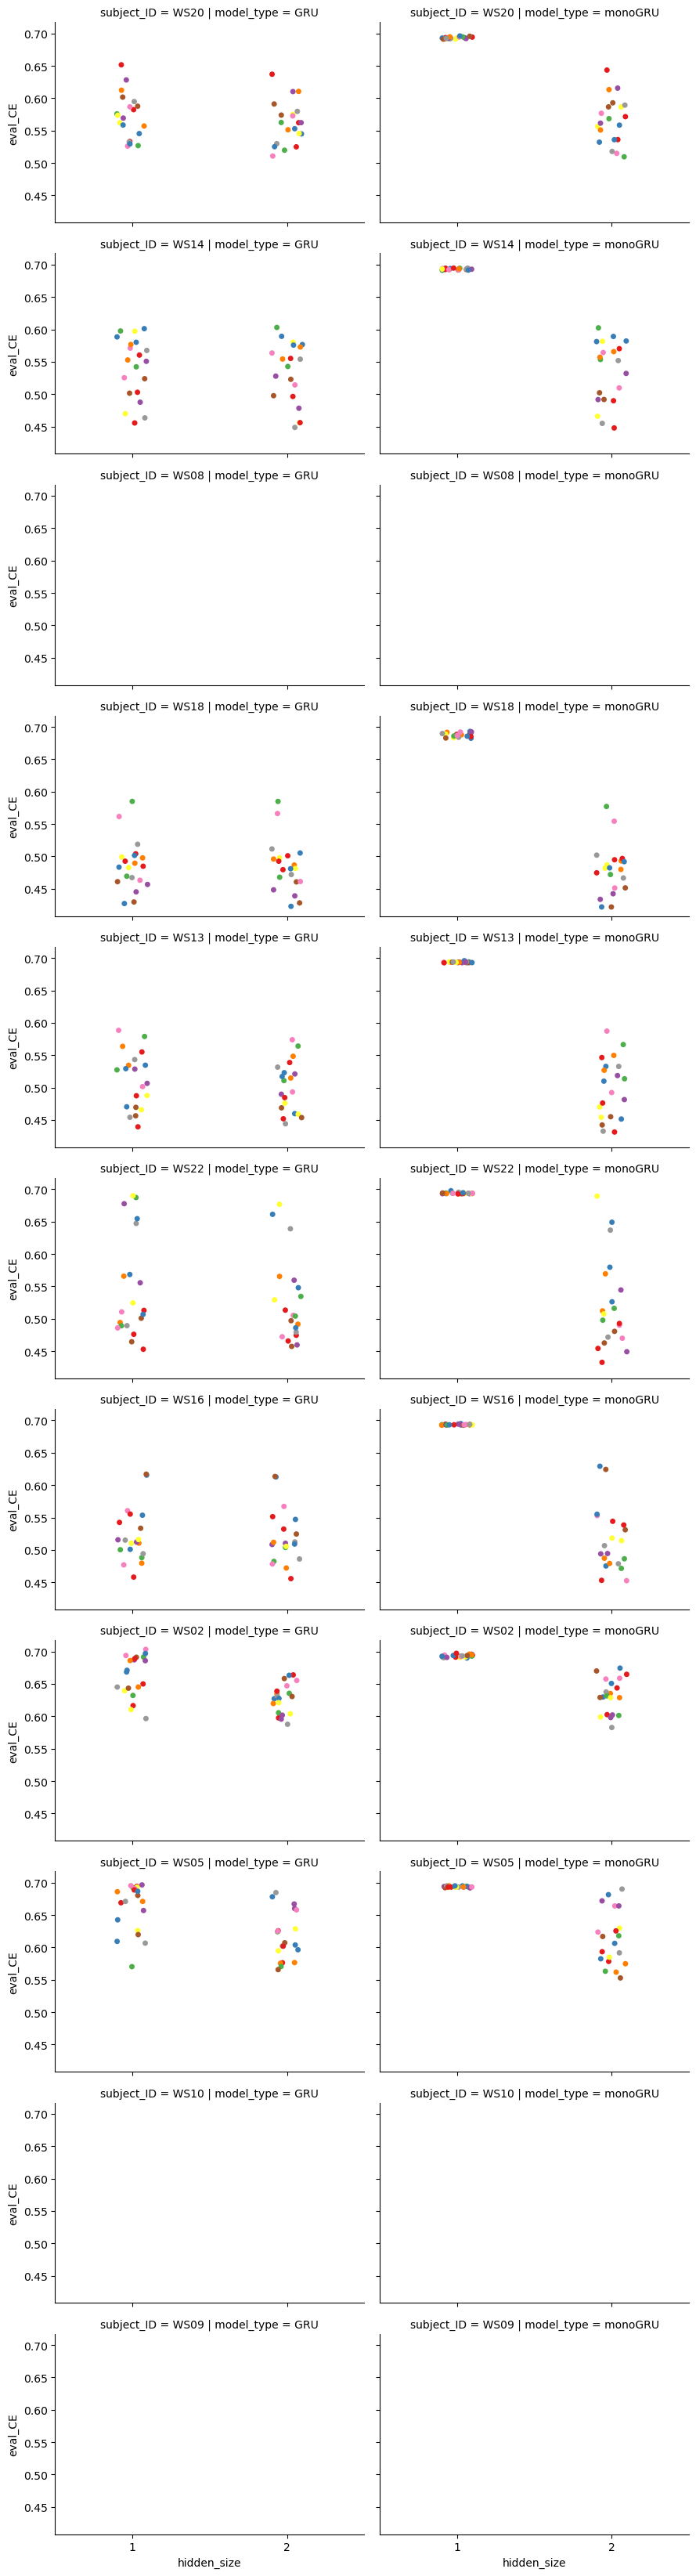

In [22]:
#Plot model performance across seeds and architectures:
filtered_df = pd.concat([info_df.query('model_type == "GRU" and constraint == "sparsity" and nonlinearity == "tanh"'),
                        info_df.query('model_type == "monoGRU" and constraint == "energy" and nonlinearity == "relu"')])
filtered_df['hidden_size'] = filtered_df['hidden_size'].astype(str)

g = sns.FacetGrid(filtered_df, row = 'subject_ID', col='model_type',  aspect = 1.5)

g.map_dataframe(sns.stripplot,x='hidden_size',y='eval_CE',
                hue='train_seed', palette="Set1",)


In [33]:
info_df.query('subject_ID == "WS16" and train_seed==1')

,subject_ID,train_seed,model_type,hidden_size,nonlinearity,input_encoding,constraint,nm_size,nm_dim,nm_mode,model_id,save_path,data_path,completed,eval_CE,best_weight_seed
160,WS16,1,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.500918,18.0
161,WS16,1,monoGRU,2,relu,unipolar,energy,1,1,row,2_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.453174,1.0
162,WS16,1,monoGRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.468895,17.0
163,WS16,1,monoGRU,2,tanh,unipolar,sparsity,1,1,row,2_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.464640,14.0
164,WS16,1,GRU,1,relu,unipolar,energy,1,1,row,1_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.463278,20.0
165,WS16,1,GRU,2,relu,unipolar,energy,1,1,row,2_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.452346,18.0
166,WS16,1,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.459779,12.0
167,WS16,1,GRU,2,tanh,unipolar,sparsity,1,1,row,2_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.456036,4.0


In [99]:
info_df.columns

Index(['subject_ID', 'train_seed', 'model_type', 'hidden_size', 'nonlinearity',
       'input_encoding', 'constraint', 'nm_size', 'nm_dim', 'nm_mode',
       'model_id', 'save_path', 'data_path', 'completed', 'eval_CE',
       'best_weight_seed'],
      dtype='object')

In [31]:
def closest_to_median(subdf):
    med = subdf["eval_CE"].median()
    idx = (subdf["eval_CE"] - med).abs().idxmin()
    return subdf.loc[idx, :]

median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)
median_df

/tmp/ipykernel_3990209/1906305871.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)


,subject_ID,train_seed,model_type,hidden_size,nonlinearity,input_encoding,constraint,nm_size,nm_dim,nm_mode,model_id,save_path,data_path,completed,eval_CE,best_weight_seed
0,WS02,2,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS02/random_seed_2...,NM_TinyRNN/data/AB_behaviour/WS02,1,0.671014,4.0
1,WS05,16,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS05/random_seed_1...,NM_TinyRNN/data/AB_behaviour/WS05,1,0.680301,1.0
2,WS13,12,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS13/random_seed_1...,NM_TinyRNN/data/AB_behaviour/WS13,1,0.527342,3.0
3,WS14,5,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS14/random_seed_5...,NM_TinyRNN/data/AB_behaviour/WS14,1,0.552795,5.0
4,WS16,9,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS16/random_seed_9...,NM_TinyRNN/data/AB_behaviour/WS16,1,0.515060,2.0
5,WS18,1,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS18/random_seed_1...,NM_TinyRNN/data/AB_behaviour/WS18,1,0.484872,4.0
6,WS20,13,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS20/random_seed_1...,NM_TinyRNN/data/AB_behaviour/WS20,1,0.569328,3.0
7,WS22,8,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA/WS22/random_seed_8...,NM_TinyRNN/data/AB_behaviour/WS22,1,0.510595,5.0
8,WS02,12,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA/WS02/random_seed_1...,NM_TinyRNN/data/AB_behaviour/WS02,1,0.692888,1.0
9,WS05,16,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA/WS05/random_seed_1...,NM_TinyRNN/data/AB_behaviour/WS05,1,0.693221,1.0


In [34]:
## Code to get 'median_df' and copy over the median-performing models for testing and comparisons

def closest_to_median(subdf):
    med = subdf["eval_CE"].median()
    idx = (subdf["eval_CE"] - med).abs().idxmin()
    return subdf.loc[idx, :]

median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)
median_df

def idx_min(subdf):
    min = subdf["eval_CE"].min()
    idx = (subdf["eval_CE"] - min).abs().idxmin()
    return subdf.loc[idx, :]

min_df = info_df.groupby("model_id").apply(idx_min).reset_index(drop=True)

import os
import shutil
from pathlib import Path

def copy_median_models(df, example_path):
    """
    Copy median performing model files into EXAMPLE_PATH/<model_type>/.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['save_path', 'model_type', 'model_ID'].
        save_path should be a pathlib.Path pointing to the model directory.
    example_path : str or Path
        Parent directory where copies will be stored.
    """
    example_path = Path(example_path)
    example_path.mkdir(parents=True, exist_ok=True)

    # files we want to copy for each model
    file_suffixes = [
        "_info.json",
        "_model_state.pth",
        "_training_losses.htsv",
        "_trials_data.htsv",
    ]
    
    for _, row in df.iterrows():
        save_path = Path(row["save_path"])
        model_type = row["model_type"]
        model_id = row["model_id"]
        subject_ID = row["subject_ID"]
        

        # make sure destination subfolder exists
        dest_dir = example_path /subject_ID/ model_type
        dest_dir.mkdir(parents=True, exist_ok=True)

        for suffix in file_suffixes:
            src = save_path / f"weight_seed_{int(row['best_weight_seed'])}/{model_id}{suffix}"
            dst = dest_dir / f"{model_id}{suffix}"
            if src.exists():
                shutil.copy(src, dst)
                print(f"Copied {src} → {dst}")
            else:
                print(f"Warning: {src} not found!")

# Example usage:
copy_median_models(median_df, Path('./NM_TinyRNN/data/rnns/subject_examples'))


/tmp/ipykernel_3990209/429264787.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)
/tmp/ipykernel_3990209/429264787.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_df = info_df.groupby("model_id").apply(idx_min).reset_index(drop=True)


Copied NM_TinyRNN/data/rnns/run_DA/WS02/random_seed_2/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_info.json → NM_TinyRNN/data/rnns/subject_examples/WS02/GRU/1_unit_GRU_tanh_unipolar_info.json
Copied NM_TinyRNN/data/rnns/run_DA/WS02/random_seed_2/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_model_state.pth → NM_TinyRNN/data/rnns/subject_examples/WS02/GRU/1_unit_GRU_tanh_unipolar_model_state.pth
Copied NM_TinyRNN/data/rnns/run_DA/WS02/random_seed_2/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_training_losses.htsv → NM_TinyRNN/data/rnns/subject_examples/WS02/GRU/1_unit_GRU_tanh_unipolar_training_losses.htsv
Copied NM_TinyRNN/data/rnns/run_DA/WS02/random_seed_2/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_trials_data.htsv → NM_TinyRNN/data/rnns/subject_examples/WS02/GRU/1_unit_GRU_tanh_unipolar_trials_data.htsv
Copied NM_TinyRNN/data/rnns/run_DA/WS05/random_seed_16/GRU/sparsity/weight_seed_1/1_unit_GRU_tanh_unipolar_info.json → NM_TinyRNN/data/rnns/subject_exam

### Model performance and selection

on WS18 we have run 10 train seeds, on GRU, monoGRU, monoGRU2, and stereoGRU architectures. The bet model is saved out of 10 weight initialisation seeds. Here we've run models with and without energy constraint, as well as with tanh and relu activation, or with bipolar and unipolar inputs. 

This should give us an idea for what architecture to present on the COSYNE abstract.

NOTE: there was a bug with the 

In [13]:
# you've trained a bunch of models with pat
#Here we append the evaluation performance to the model info dataframe
from NM_TinyRNN.code.models import parallelised_training as pat
from pathlib import Path
import numpy as np
import json
info_df = pat.get_train_info_df()
evals = []
seeds = []
for model_info in info_df.itertuples():
    model_dir = Path(model_info.save_path)
    model_id = f'{model_info.model_id}_{model_info.nonlinearity}_{model_info.input_encoding}'
    eval_json_path = model_dir / f'{model_id}_info.json'
    #open the json and extract eval performance for each model:
    if eval_json_path.exists():
        with open(eval_json_path, 'r') as f:
            eval_info = json.load(f)
        evals.append(eval_info['eval_pred_loss'])
    else:
        evals.append(np.nan)
info_df['eval_CE'] = evals


NM_TinyRNN/data/AB_behaviour/README.md
NM_TinyRNN/data/AB_behaviour/WS18
NM_TinyRNN/data/AB_behaviour/WS16


In [25]:
info_df.columns

Index(['subject_ID', 'train_seed', 'model_type', 'hidden_size', 'nonlinearity',
       'input_encoding', 'constraint', 'nm_size', 'nm_dim', 'nm_mode',
       'model_id', 'save_path', 'data_path', 'completed', 'eval_CE'],
      dtype='object')

/nfs/nhome/live/cburns/miniconda3/envs/NM_TinyRNN/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


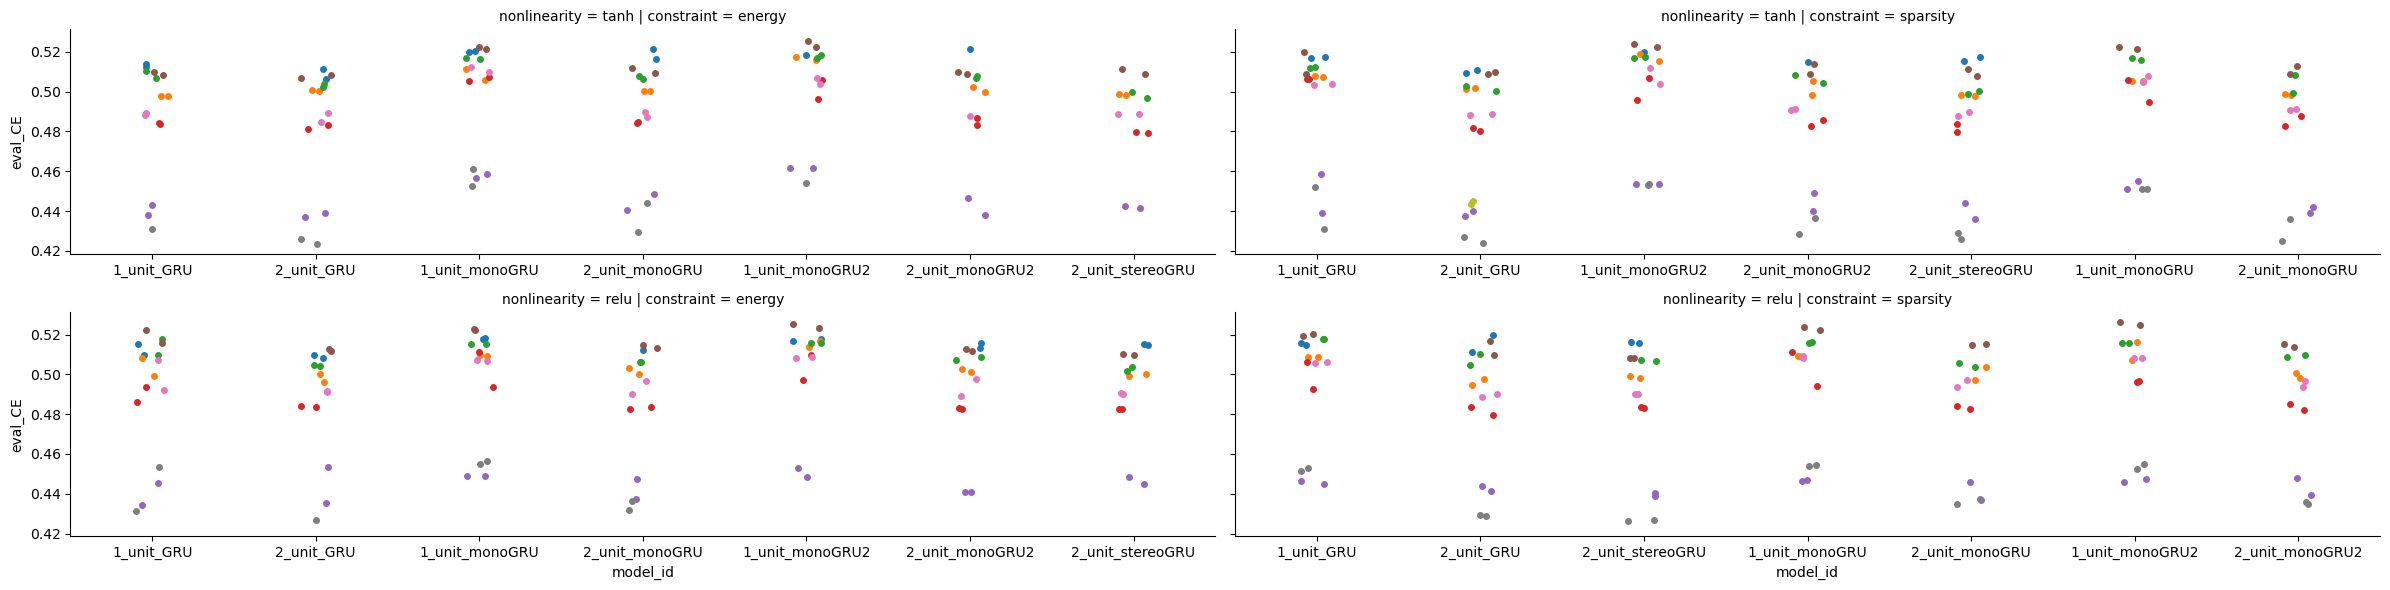

In [ ]:
#let's compare 1D and 2D model
info_df = info_df.dropna()
import seaborn as sns
g = sns.FacetGrid(info_df, col='constraint', row = 'nonlinearity',
                  hue='train_seed', sharey=True, sharex=False, aspect=4)

g.map(sns.stripplot, 'model_id', 'eval_CE', jitter=True, dodge=True)


<Axes: xlabel='model_id', ylabel='eval_CE'>

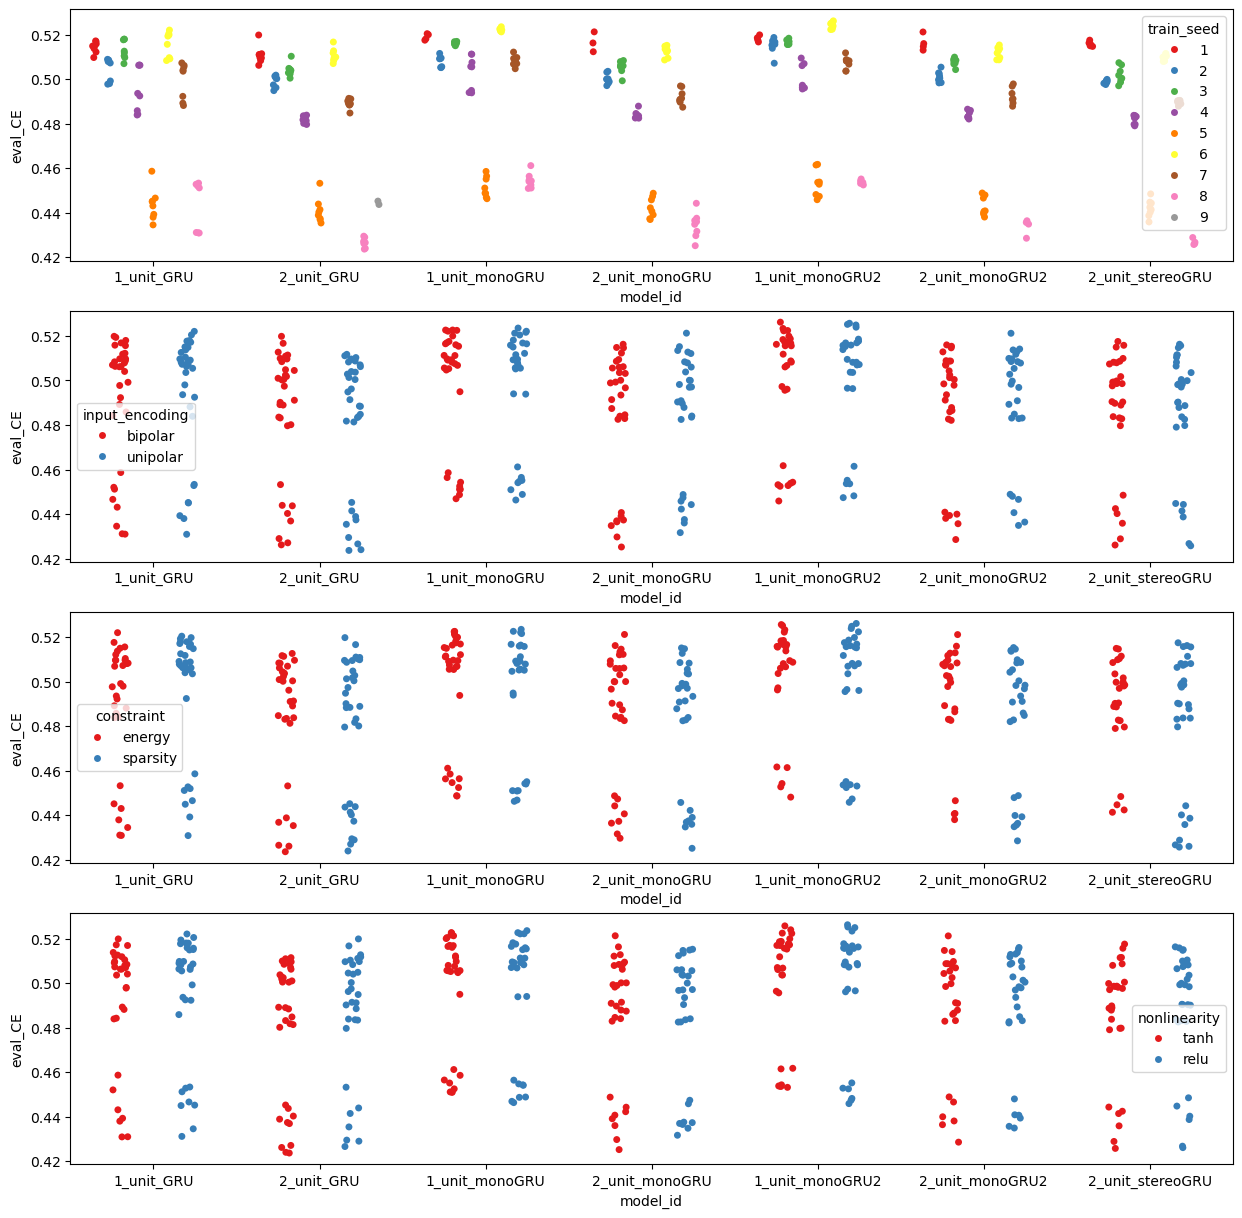

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,1, figsize = (15,15))
sns.stripplot(info_df, x='model_id', y='eval_CE', 
              hue='train_seed', 
              jitter=True, dodge=True,ax = ax[0],
              palette = 'Set1')
sns.stripplot(info_df, x='model_id', y='eval_CE', 
              hue='nonlinearity', 
              jitter=True, dodge=True,ax = ax[3],
              palette = 'Set1')

sns.stripplot(info_df, x='model_id', y='eval_CE', 
              hue='input_encoding', 
              jitter=True, dodge=True,ax = ax[1],
              palette = 'Set1')

sns.stripplot(info_df, x='model_id', y='eval_CE', 
              hue='constraint', 
              jitter=True, dodge=True,ax = ax[2],
              palette = 'Set1')